# Exploring Embeddings with Gensim / vector math

Earlier we trained a model to predict the ratings users would give to movies using a network with embeddings learned for each movie and user. Embeddings are powerful! But how do they actually work?

Previously, I claimed that embeddings capture the 'meaning' of the objects they represent, and discover useful latent structure. Let's see that using Genism.

In this notebook, we perform some exploration of our trained movie embeddings, using some of the Gensim tools.

## Looking up embeddings
Let's load a model we trained earlier so we can investigate the embedding weights that it learned.

In [1]:
#To get started, run the setup cell below to import the libraries we'll be using, load our raw embedding data, 
#and wrap it in a `WordEmbeddingsKeyedVectors` object.

import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors


model = keras.models.load_model('best_model.h5')

"""The embedding weights are part of the model's internals, so we'll have to do a bit of digging around to access them. 
We'll grab the layer responsible for embedding movies, and use the get_weights() method to get its learned weights."""

emb_layer = model.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()
movie_embedding_size = w.shape[1]

w.shape


c:\users\sahit\venv\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(26744, 8)

Our weight matrix has 26,744 rows for that many movies. Each row is 8 numbers - the size of our movie embeddings.

Let's look at an example movie vector:


In [12]:
w[0]

array([ 0.28126636, -0.01599566, -0.02855809,  0.53167796,  0.7911056 ,
       -0.33743697,  0.13268907, -0.57071614], dtype=float32)

What movie is this the embedding of? Let's load up our dataframe of movie metadata.



In [19]:
movies_df = pd.read_csv('movies.csv')

movies_df.head()


,movieId,title,genres,year,key,n_ratings,mean_rating
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,49695,3.921240
1,1,Jumanji,Adventure|Children|Fantasy,1995,Jumanji,22243,3.211977
2,2,Grumpier Old Men,Comedy|Romance,1995,Grumpier Old Men,12735,3.151040
3,3,Waiting to Exhale,Comedy|Drama|Romance,1995,Waiting to Exhale,2756,2.861393
4,4,Father of the Bride Part II,Comedy,1995,Father of the Bride Part II,12161,3.064592


Of course, it's Toy Story! 

So how do we check whether these representations are sane and coherent?

## 1. Finding Vector similarity

A simple way to test this is to look at how close or distant pairs of movies are in the embedding space. Embeddings can be thought of as a smart distance metric. If our embedding matrix is any good, it should map similar movies (like Toy Story and Shrek) to similar vectors.

In [24]:
toy_story = w[0]
shrek = w[movies_df.loc[
    movies_df.title == 'Shrek',
    'movieId'].iloc[0]]

exorcist = w[movies_df.loc[
    movies_df.title == 'The Exorcist',
    'movieId'].iloc[0]]



In [25]:
#If we wanted to assign a single number to their similarity, 
#we could calculate the euclidean distance between these two vectors.

from scipy.spatial import distance

distance.euclidean(toy_story, shrek)

0.6755921840667725

### Cosine Distance

When judging the similarity of embeddings, it's more common to use cosine similarity because cosine distance with so many deep learning techniques, is "empirically, it works well". 

In brief, the cosine similarity of two vectors ranges from -1 to 1, and is a function of the angle between the vectors. If two vectors point in the same direction, their cosine similarity is 1. If they point in opposite directions, it's -1. If they're orthogonal (i.e. at right angles), their cosine similarity is 0.

Cosine distance is just defined as 1 minus the cosine similarity (and therefore ranges from 0 to 2).

Let's calculate a couple cosine distances between movie vectors:

In [26]:
distance.cosine(toy_story, shrek)

0.1716126799583435

In [27]:
distance.cosine(toy_story, exorcist)

0.5123173594474792

Which movies are most similar to Toy Story? Which movies fall right between Psycho and Scream in the embedding space? We could explore that using a library for exactly this sort of work: **Gensim**.

I'll instantiate an instance of WordEmbeddingsKeyedVectors with our model's movie embeddings and the titles of the corresponding movies.

>Aside: Gensim's is a topic modelling library it's docs and many of its class and method names refer to word embeddings. While the library is most frequently used in the text domain, we can use it to explore embeddings of any sort.

In [28]:
kv = WordEmbeddingsKeyedVectors(movie_embedding_size)

threshold = 100

movies = movies_df[movies_df.n_ratings >= threshold].reset_index(drop=False)

kv.add(
    movies['key'].values,
    w[movies.movieId]
)

In [44]:
# looking up a movie, you may want to find similar movies for

movies[movies.title.str.contains('Titanic')]


,index,movieId,title,genres,year,key,n_ratings,mean_rating
1429,1661,1661,Titanic,Drama|Romance,1997,Titanic (1997),32238,3.338188
1793,2073,2073,"Chambermaid on the Titanic, The (Femme de cham...",Romance,1998,"Chambermaid on the Titanic, The (Femme de cham...",119,3.310924
2825,3315,3315,Raise the Titanic,Drama|Thriller,1980,Raise the Titanic,198,2.578283
2826,3316,3316,Titanic,Action|Drama,1953,Titanic (1953),1733,3.258800
3975,4768,4768,Titanica,Documentary|IMAX,1992,Titanica,110,3.104545


Okay, so which movies are most similar to Titanic?

We use `kv.most_similar` method on a few of your favourite movies.

In [38]:
# Note: you should always pass 'key' attribute of movies dataset to find similar genre movies
kv.most_similar('Titanic (1953)')

[("My Best Friend's Wedding", 0.9632135629653931),
 ('Beaches', 0.9585211277008057),
 ('Mrs. Doubtfire', 0.9567484259605408),
 ('The River Wild', 0.9447559118270874),
 ('Homeward Bound: The Incredible Journey', 0.9379501342773438),
 ('Titanic (1997)', 0.9370995163917542),
 ('Ghost', 0.9368044137954712),
 ('My Girl', 0.9362284541130066),
 ('Sleepless in Seattle', 0.9305105209350586),
 ("You've Got Mail", 0.928631603717804)]

As you can see from above results we got the similar genre movies with highest distance score value. For fun we can give many movies to find the similar recommendations based on our interest   

So it's learned something about 3-d animated kids flick, but maybe that was just a fluke. Let's look at the closest neighbours for a few more movies from a variety of genres:

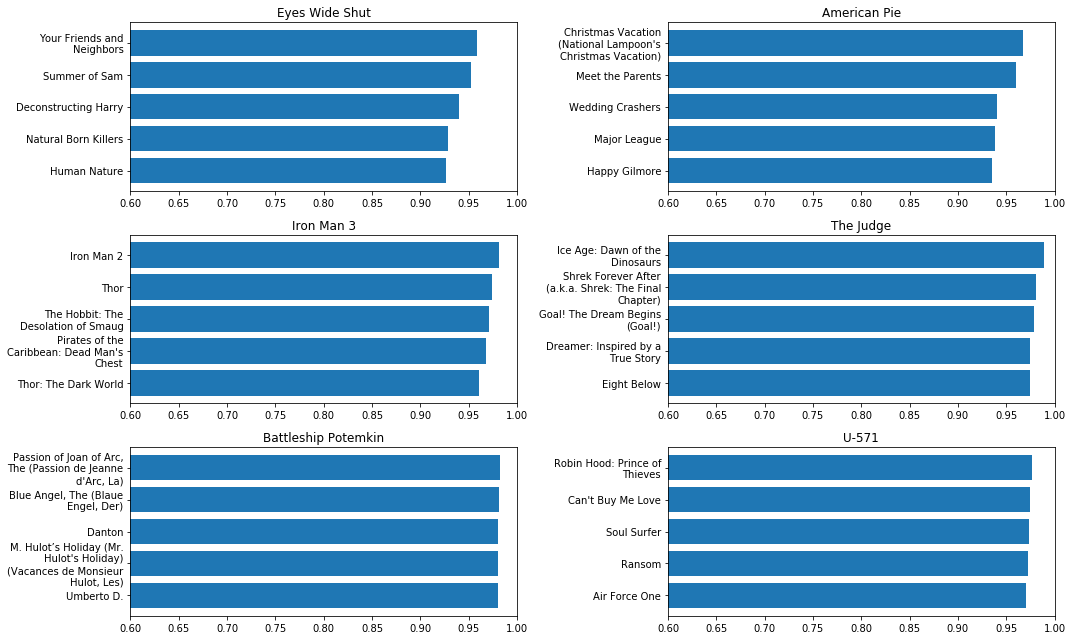

In [59]:
import textwrap
movies = ['Eyes Wide Shut', 'American Pie', 'Iron Man 3', 'The Judge',
          'Battleship Potemkin', 'U-571'
]

def plot_most_similar(movie, ax, topn=5):
    sim = kv.most_similar(movie, topn=topn)[::-1]
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in sim]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(movie)    

fig, axes = plt.subplots(3, 2, figsize=(15, 9))

for movie, ax in zip(movies, axes.flatten()):
    plot_most_similar(movie, ax)
    
fig.tight_layout()

Thriller/mystery,Romanntic comedy, superhero science fiction, silent drama historical, Action-comedy drama, full action genres, Our embeddings manage to nail a wide variety of cinematic niches!

## 2. Semantic vector math and Analogy solving


So far we've seen the `most_similar()` method called in the following ways:
- with a single (positive) example `m1`, giving us the movies most similar to `m1`
- with one positive example, `m1`, and one negative example, `m2`. The results seem to roughly correspond to the question "which movies exemplify the properties that `m1` has and `m2` doesn't?"
- with two positive examples, `m1` and `m2`, and one negative example, `m3`, which answers the analogy "`m3` is to `m2` as `m1` is to ____".

What do you think will happen (mathematically, and semantically) if we call it with two positive examples, and no negative examples? 

In the code cell below, we call `most_similar()` and pass two positive movie samples and we'll see how well method can predict what kinds of movies.

In [46]:
# TODO: call most_similar with the movies "Legally Blonde" and "Mission: Impossible" as positive examples,
# and assign the results to the variable legally_impossible
legally_impossible = kv.most_similar(positive = ['Legally Blonde', 'Mission: Impossible'])
legally_impossible

[("Can't Buy Me Love", 0.9842299222946167),
 ('Sinbad: Legend of the Seven Seas', 0.9808305501937866),
 ('Blue Collar Comedy Tour: The Movie', 0.9761831760406494),
 ('Jumanji', 0.9754784107208252),
 ("It's a Boy Girl Thing", 0.9717432260513306),
 ('U-571', 0.9682282209396362),
 ('Shrek Forever After (a.k.a. Shrek: The Final Chapter)', 0.9675494432449341),
 ('Night at the Museum', 0.9652889966964722),
 ('Eight Below', 0.9649732112884521),
 ('The Judge', 0.9641647338867188)]

Try experimenting with adding other pairs of movies. Do you see a pattern emerging?

What do you think happens if we pass in the same movie twice?

In [48]:
# Feel free to continue experimenting here.

same_movie = kv.most_similar(positive=['Titanic (1953)', 'Titanic (1953)'])
same_movie

[("My Best Friend's Wedding", 0.9632135629653931),
 ('Beaches', 0.9585211277008057),
 ('Mrs. Doubtfire', 0.9567484259605408),
 ('The River Wild', 0.9447559118270874),
 ('Homeward Bound: The Incredible Journey', 0.9379501342773438),
 ('Titanic (1997)', 0.9370995163917542),
 ('Ghost', 0.9368044137954712),
 ('My Girl', 0.9362284541130066),
 ('Sleepless in Seattle', 0.9305105209350586),
 ("You've Got Mail", 0.928631603717804)]

Passing in two positive examples, `m1` and `m2`, finds the vectors that are most similar to `m1 + m2`. Semantically, this corresponds to movies that are about halfway between `m1` and `m2` in terms of meaning. 

In light of this interpretation, some of our `legally_impossible` results make a lot of sense. *Eight Below*, *Jumanji*, and *Night at the Museum* are all examples of movies the "comedy" properties of *Legally Blonde* with the action/adventure movie properties of *Mission: Impossible*.

What happens if we run something like `kv.most_similar(positive=['Titanic (1953)', 'Titanic (1953)'])`? We get the exact same results as `kv.most_similar('Titanic (1953)')`. The reason comes down to our use of cosine distance. If we add a movie vector `m1` to itself, we get a vector that's twice as long, but its *angle* remains the same. So for any pair of movies `m1`, `m2`, `distance.cosine(m1, m2) == distance.cosine(m1+m1, m2)`.


**Bonus**: Pick a movie you like (let's call it `m`), and see if you can find two other movies, `m1` and `m2` such that `m1 + m2 ≈ m`. Of course you're pretty likely to succeed if you choose two movies which are each similar to `m`, but can you come up with a pair of very *different* movies that have `m` right between them? Again, if you're successful here, feel free to share on [the forums](https://www.kaggle.com/learn-forum).

## 3. Cosine distance vs. Euclidean distance

If you're familiar with linear algebra, you may know that the cosine distance and euclidean distance of two vectors are equivalent (up to a scaling factor) if those vectors have the same length. In particular, when our vectors both have length 1, their euclidean distance is just twice their cosine distance.

Given that we cared about using cosine distance rather than Euclidean distance, we must have some reason to believe that our embedding vectors vary in length. But how much? And is there any pattern to which movies' vectors are long or short?

### 3a. Distribution of lengths

Just as there are lots of definitions of distance, there are lots of definitions of length. But we'll be using the familiar notion, technically called the 'Euclidean norm' or 'L2 norm'. What's the length of the vector `(3, 4)`? Well, if we start at `(0, 0)`, walk 3 steps to the right, and then 4 steps up, we'll get a right triangle where the hypotenuse connects `(3, 4)` to `(0, 0)`. By the Pythagorean theorem, the length of that hypotenuse is $\sqrt{3^2 + 4^2} = \sqrt{25} = 5$. We can extend the calculation to any number of dimensions - for example, the L2 norm of the vector `(1, 1, 3, 5)` is $\sqrt{1^2 + 1^2 + 3^2 + 5^2} = 6$.

Fortunately, we don't need to implement the calculations ourselves. Given a vector, the function [`numpy.linalg.norm`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html) returns its L2 norm. Run the cell below to calculate the L2 norm of our model's first movie embedding vector:

In [49]:
np.linalg.norm(w[0])

1.2024553

Fill in the missing code in the cell below to create a variable `norms`, containing the L2 norms of all the model's movie embeddings.

In [51]:
norms = np.linalg.norm(w, axis =1)


As we have `norms`, we generate a visualization of the distribution of lengths of our movie embedding vectors.

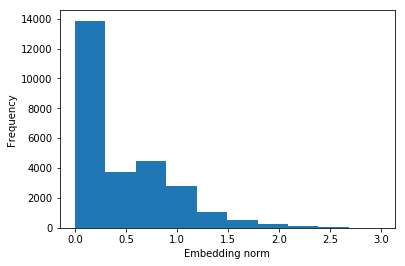

In [52]:
norm_series = pd.Series(norms)
ax = norm_series.plot.hist()
ax.set_xlabel('Embedding norm');

### 3b. Patterns in vector lengths?

We add a column called `norm` containing the length of each movie's embedding to our DataFrame containing all movies (`movies_df`).

In [53]:
# TODO: Your code goes here. Add the column "norm" to our movies dataframe.
movies_df['norm'] = norms

movies_df.head()

,movieId,title,genres,year,key,n_ratings,mean_rating,norm
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,49695,3.921240,1.202455
1,1,Jumanji,Adventure|Children|Fantasy,1995,Jumanji,22243,3.211977,1.150732
2,2,Grumpier Old Men,Comedy|Romance,1995,Grumpier Old Men,12735,3.151040,1.309365
3,3,Waiting to Exhale,Comedy|Drama|Romance,1995,Waiting to Exhale,2756,2.861393,1.467930
4,4,Father of the Bride Part II,Comedy,1995,Father of the Bride Part II,12161,3.064592,1.487438


Run the cells below to see the movies with the largest and smallest embedding vectors. To find a pattern if any

In [54]:
n = 5
# Movies with the smallest embeddings (as measured by L2 norm)
movies_df.sort_values(by='norm').head(n)

,movieId,title,genres,year,key,n_ratings,mean_rating,norm
25395,25395,Killer Pad,Comedy|Horror,2008,Killer Pad,1,2.0,0.0
25321,25321,Hotel Very Welcome,Comedy|Drama,2007,Hotel Very Welcome,1,3.5,0.0
21304,21304,Page Miss Glory,Comedy,1935,Page Miss Glory,1,2.5,0.0
21245,21245,Love Is a Woman (Death Is a Woman),Crime|Drama|Mystery,1966,Love Is a Woman (Death Is a Woman),1,3.0,0.0
21098,21098,Days of Grace (Días de gracia),Thriller,2011,Days of Grace (Días de gracia),1,3.5,0.0


In [56]:
# Movies with the largest embeddings
movies_df.sort_values(by='norm', ascending=False).head(n)

,movieId,title,genres,year,key,n_ratings,mean_rating,norm
6373,6373,From Justin to Kelly,Musical|Romance,2003,From Justin to Kelly,426,0.973005,2.985721
9754,9754,Son of the Mask,Adventure|Children|Comedy|Fantasy,2005,Son of the Mask,467,1.252677,2.943794
11594,11594,Epic Movie,Adventure|Comedy,2007,Epic Movie,899,1.488877,2.906200
4679,4679,Glitter,Drama|Musical|Romance,2001,Glitter,685,1.124088,2.823681
6477,6477,Gigli,Comedy|Crime|Romance,2003,Gigli,701,1.164051,2.801580


Below are some speculations or observations.

>We have some movies whose embeddinging norms are 0 or very close to it - they also seem to be among the movies with the fewest ratings in the dataset. This is consistent with what we'd expect from a model trained with an L2 weight penalty on embeddings - there's a cost to increasing an embedding's size.

>Memorizing some properties of an obscure movie that only occurs once or twice in the dataset won't do much to decrease our overall error - so it's not worth paying the regularization cost.

>On the other hand, the movies with the biggest embeddings are *not* necessarily the ones with the most ratings in the dataset. 